In [1]:
import os
n_cores = 5
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import pandas as pd
from online_cp import PluginMartingale
from online_cp.CPS import NearestNeighboursPredictionMachine, RidgePredictionMachine
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
rnd_gen = np.random.default_rng(2025)
from copy import deepcopy
from sklearn.preprocessing import minmax_scale
MACHINE_EPSILON = lambda x: np.abs(x) * np.finfo(np.float64).eps

In [2]:
data = pd.read_csv('export.csv', parse_dates=True, index_col='Time')
data = data.asfreq('h')
data = data.dropna()

Winter_train = data[:4308]
Winter_test = data[4308:]

D = 24

initial_training_set_size = D + Winter_train.shape[0]
knonw_initially = data[:initial_training_set_size]
future = data[initial_training_set_size:]

X_initial_train = knonw_initially[:-D]
y_initial_train = knonw_initially[D:].demand

In [3]:
hourly = False

neighbours = 101

autotune=True

normalisation = False

pred_cols = ['demand', f'temperature_forecast', f'Hour_{D}', f'Working_day_{D}']
learn_cols = ['demand', f'temperature_{D}', f'Hour_{D}', f'Working_day_{D}']
Hours = data.index.hour.unique().to_numpy()

if normalisation:

    if hourly:
        X_train_dict = {hour: X_initial_train.loc[X_initial_train.index.hour==hour][learn_cols] for hour in Hours}
        y_train_dict = {hour: y_initial_train.loc[X_initial_train.index.hour==hour].values for hour in Hours}

        # hourly_CPS = {hour: NearestNeighboursPredictionMachine(k=neighbours) for hour in Hours}
        hourly_CPS = {hour: RidgePredictionMachine(autotune=autotune) for hour in Hours}

        [hourly_CPS[hour].learn_initial_training_set(
                X=minmax_scale(X_train_dict[hour]),
                y=y_train_dict[hour]
                ) for hour in Hours]

    else:
        X_train = X_initial_train[learn_cols]
        y_train = y_initial_train

        # cps = NearestNeighboursPredictionMachine(k=neighbours)
        cps = RidgePredictionMachine(autotune=autotune)
        cps.learn_initial_training_set(
            X=minmax_scale(X_train),
            y=y_initial_train.values
        )

    res = np.zeros(shape=(future.shape[0]-D, 3))
    p_values = np.zeros(shape=(future.shape[0]-D,))
    p_values_low = np.zeros(shape=(future.shape[0]-D,))
    p_values_high = np.zeros(shape=(future.shape[0]-D,))
    p_values_cat = {i: [] for i in Hours}

    dists = {}
    protected_dists = {}

    limit = 40

    j = 0
    for i, obj in tqdm(future.iterrows(), total=future.shape[0], desc=f'Decision protocol {D}h (normalised data)'):
        tau = rnd_gen.uniform(0, 1)

        # This is all we know now
        known = data[data.index <= i]

        if hourly:
            cps = hourly_CPS[i.hour]   
            X_train = X_train_dict[i.hour]
            y_train = y_train_dict[i.hour]

        # Reality outputs object
        x = obj[pred_cols].values

        # And we scale it
        X_scale = np.vstack([X_train, x])
        x = minmax_scale(X_scale)[-1]

        # Forecaster outputs conformal predictive distribution
        cpd = cps.predict_cpd(x=x)

        pred = cpd(limit, tau)

        # Reality outputs label (the demand now) for the object x_{t-24}
        y = obj.demand
        x_minus_24 = known.loc[i - pd.Timedelta(D, 'h')][learn_cols].values
        # And we scale it
        X_train = np.vstack([X_train, x_minus_24])
        y_train = np.append(y_train, y)
        x_minus_24 = minmax_scale(X_scale)[-1]

        # Learn new example (relearn everything)
        cat_learn = (i - pd.Timedelta(D, 'h')).hour
        if hourly:
            hourly_CPS[cat_learn].learn_initial_training_set(X=minmax_scale(X_train), y=y_train)
        else:
            cps.learn_initial_training_set(X=minmax_scale(X_train), y=y_train)

        # hourly_CPS[cat_learn].learn_one(x_minus_24, y)
        # cps.learn_one(x_minus_24, y)

        if j < future.shape[0] - 24:
            y_plus_24 = future.loc[i + pd.Timedelta(D, 'h')].demand
            res[j, 0] = pred
            res[j, 1] = y_plus_24
            res[j, 2] = tau
            dists[j] = cpd

            p_low, p_high = cpd(y_plus_24)
            p = cpd(y_plus_24, tau)
            p_values[j] = p
            p_values_low[j] = p_low
            p_values_high[j] = p_high
            p_values_cat[cat_learn].append(p)

        j += 1

else:

    if hourly:
        # hourly_CPS = {hour: NearestNeighboursPredictionMachine(k=neighbours) for hour in Hours}
        hourly_CPS = {hour: RidgePredictionMachine(autotune=autotune) for hour in Hours}

        [hourly_CPS[hour].learn_initial_training_set(
                X=X_initial_train.loc[X_initial_train.index.hour==hour][learn_cols].values,
                y=y_initial_train.loc[X_initial_train.index.hour==hour].values
                ) for hour in Hours]
    else:
        # cps = NearestNeighboursPredictionMachine(k=neighbours)
        cps = RidgePredictionMachine(autotune=autotune)
        cps.learn_initial_training_set(
            X=X_initial_train[learn_cols].values,
            y=y_initial_train.values
        )


    res = np.zeros(shape=(future.shape[0]-D, 3))
    p_values = np.zeros(shape=(future.shape[0]-D,))
    p_values_low = np.zeros(shape=(future.shape[0]-D,))
    p_values_high = np.zeros(shape=(future.shape[0]-D,))
    p_values_cat = {i: [] for i in Hours}

    dists = {}
    protected_dists = {}

    limit = 40

    j = 0
    for i, obj in tqdm(future.iterrows(), total=future.shape[0], desc=f'Decision protocol {D}h (raw data)'):
        tau = rnd_gen.uniform(0, 1)

        # This is all we know now
        known = data[data.index <= i]

        if hourly:
            cps = hourly_CPS[i.hour]   

        # Reality outputs object
        x = obj[pred_cols].values

        # Forecaster outputs conformal predictive distribution
        cpd = cps.predict_cpd(x=x)

        # Predict lilit
        pred = cpd(limit, tau)

        # Reality outputs label (the demand now) for the object x_{t-24}
        y = obj.demand
        x_minus_24 = known.loc[i - pd.Timedelta(D, 'h')][learn_cols].values

        # Learn new example
        cat_learn = (i - pd.Timedelta(D, 'h')).hour
        if hourly:
            hourly_CPS[cat_learn].learn_one(x_minus_24, y)
        else:
            cps.learn_one(x_minus_24, y)

        if j < future.shape[0] - 24:
            y_plus_24 = future.loc[i + pd.Timedelta(D, 'h')].demand
            res[j, 0] = pred
            res[j, 1] = y_plus_24
            res[j, 2] = tau
            dists[j] = cpd

            p_low, p_high = cpd(y_plus_24)
            p = cpd(y_plus_24, tau)
            p_values[j] = p
            p_values_low[j] = p_low
            p_values_high[j] = p_high
            p_values_cat[cat_learn].append(p)
        j += 1

Decision protocol 24h (raw data):   0%|          | 0/2130 [00:00<?, ?it/s]

In [4]:
preds = res[:,0]
y_true = res[:,1]
Tau = res[:,2]

In [5]:
from sklearn.metrics import log_loss
base_log_loss = log_loss(y_true=(y_true <= limit).astype(int), y_pred=preds)

from sklearn.metrics import brier_score_loss
base_brier_score_loss = brier_score_loss(y_true=(y_true <= limit).astype(int), y_proba=preds)

from sklearn.metrics import roc_auc_score
base_roc_auc_score = roc_auc_score(y_true=(y_true <= limit).astype(int), y_score=preds)

from sklearn.metrics import average_precision_score
base_average_precision_score = average_precision_score(y_true=(y_true <= limit).astype(int), y_score=preds)

losses = np.array(
    [
        [base_log_loss, base_brier_score_loss, base_roc_auc_score, base_average_precision_score]
    ]
)
df_losses = pd.DataFrame(data=losses, index=['cps'], columns=['log_loss', 'brier_score', 'roc_auc', 'pr_auc'])
df_losses

,log_loss,brier_score,roc_auc,pr_auc
cps,0.106457,0.028725,0.972708,0.99792


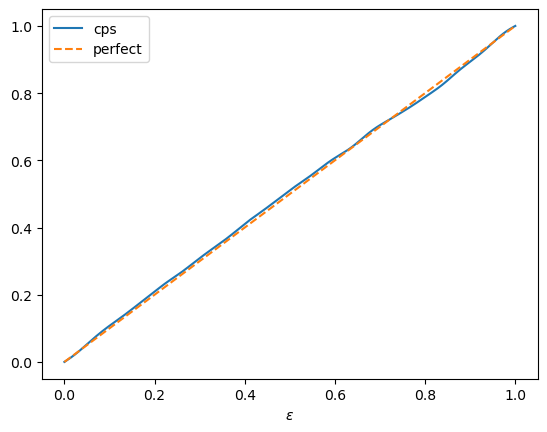

In [6]:
martingale = PluginMartingale(warnings=False)
for p in p_values:
    martingale.update_martingale_value(p)

# martingale_low = PluginMartingale(warnings=False)
# for p in p_values_low:
#     martingale_low.update_martingale_value(p)

# martingale_high = PluginMartingale(warnings=False)
# for p in p_values:
#     martingale_high.update_martingale_value(p)

prange = np.linspace(0, 1, 1000)
plt.plot(
    prange,
    martingale.B_n(prange),
    label='cps'
)
# plt.plot(
#     prange,
#     martingale_low.B_n(prange),
#     label='cps low'
# )
# plt.plot(
#     prange,
#     martingale_high.B_n(prange),
#     label='cps high'
# )
plt.plot(
    prange,
    prange,
    label='perfect',
    linestyle='--'
)
plt.xlabel(r'$\varepsilon$')
plt.legend()

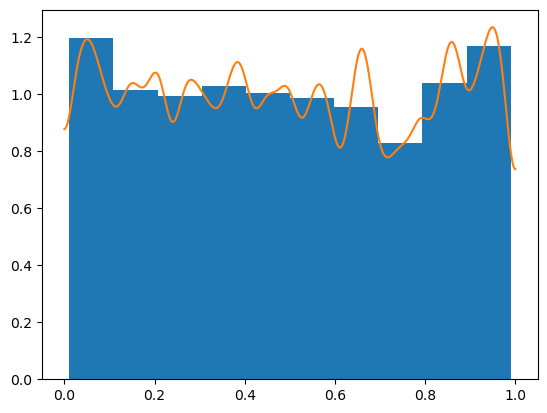

In [7]:
plt.hist(p_values, density=True)
plt.plot(
    prange,
    martingale.b_n(prange)
)

# Expected utility

In [8]:
def utility(flex, limit, demand, flex_cost=0.1, overdraw_cost=1):
    '''
    Simple utility function that takes into account the possibility to buy too little flex.
    NOTE: This is unrealistic in that we can not buy a real number of flex in practice.
    '''
    effective_demand = demand - flex # Are we above despide having flex?
    effective_above = effective_demand > limit 
    above = demand > limit # Would we have been above if we did not buy flex?
    if effective_above: # Even with flex, we are above the limit
        u = - overdraw_cost * (effective_demand - limit) - flex_cost * flex
    elif above: # We would have been over the limit if we had not had flex.
        u = overdraw_cost * (demand - limit) - flex_cost * flex
    else: # We are below no matter what.
        u = - flex_cost * flex
    return float(u)

def exp_util(cpd, d, tau=1):
    jump_points = np.unique(cpd.Y[1:-1])
    Delta_Q = np.array([utility(d, limit, y) * (cpd(y=y + MACHINE_EPSILON(y), tau=tau) - cpd(y=y - MACHINE_EPSILON(y), tau=tau)) for y in jump_points])
    return jump_points @ Delta_Q

def expectation(cpd, tau=1):
    jump_points = np.unique(cpd.Y[1:-1])
    Delta_Q = np.array([(cpd(y=y + MACHINE_EPSILON(y), tau=tau) - cpd(y=y - MACHINE_EPSILON(y), tau=tau)) for y in jump_points])
    return jump_points @ Delta_Q

In [9]:
np.where(y_true > 40)

(array([105, 106, 124, 125, 126, 127, 128, 129, 130, 131, 132, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 226, 227,
        228, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
        274, 275, 276, 289, 290, 291, 297, 298, 299, 300, 410, 411, 412,
        413, 414, 415, 416, 417, 418, 419, 420, 421, 431, 432, 433, 434,
        435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 457,
        458, 459, 460, 461, 465, 466, 467, 480, 481, 482, 483, 484, 485,
        489, 490, 491, 492, 493, 505, 506, 507]),)

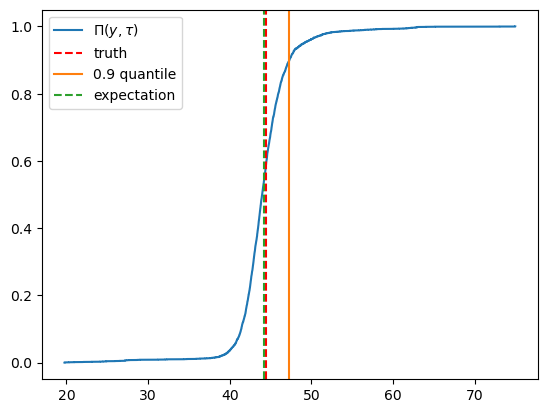

In [10]:
i = 154
cpd = dists[i]
plt.step(cpd.Y[:], (1 - tau) * cpd.L + tau * cpd.U, label=r'$\Pi(y, \tau)$')
plt.axvline(y_true[i], color='red', linestyle='--', label='truth')
plt.axvline(cpd.quantile(0.9, tau=tau), color='C1', label='0.9 quantile')
plt.axvline(expectation(cpd, tau), linestyle='--', label='expectation', color='C2')
plt.legend()

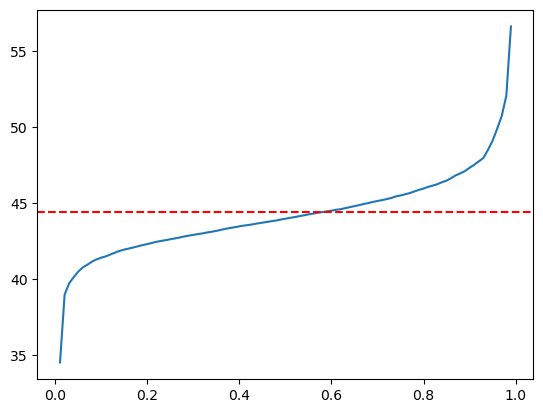

In [11]:
qrange = np.linspace(0.01, 1, endpoint=False, num=99)
plt.plot(
    qrange,
    [cpd.quantile(q, tau) for q in qrange],
    label='quantile function'
)
plt.axhline(y_true[i], linestyle='--', color='red')

In [12]:
from scipy.optimize import minimize_scalar

d_max = limit

tau = rnd_gen.uniform(0, 1)
d = minimize_scalar(lambda x: -exp_util(cpd, x, tau), bounds=(0, d_max)).x 
print()
print(f'Decicion: {d}')
print(f'Optimal decision: {max(y_true[i] - limit, 0)}')
print(f'Expected utility: {exp_util(cpd, d, tau)}')
print(f'Utility {utility(d, limit, y_true[i])}')
print()


Decicion: 12.539602341306853
Optimal decision: 4.4398184
Expected utility: 122.22349971996398
Utility 3.1858581658693144



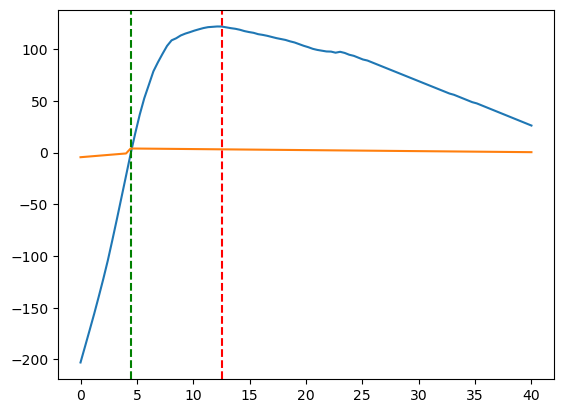

In [13]:
drange = np.linspace(0, d_max, num=100, endpoint=True)
plt.plot(
    drange,
    [exp_util(cpd, d, tau) for d in drange]
)
plt.plot(
    drange,
    [utility(d, limit, y_true[i]) for d in drange]
)
plt.axvline(max(y_true[i] - limit, 0), linestyle='--', color='green', label='optimal decision')
plt.axvline(d, linestyle='--', color='red', label='decision')

In [14]:
(data.demand > 40).sum()

167

In [15]:
print(f'Thickness: {np.diff(cpd(y))[0]}')
print(f'Exception size: {np.unique(cpd.C).shape[0] - 2}')

Thickness: 0.00022406453058480846
Exception size: 4462


# Get the predictions for each level

In [16]:
quantiles = np.linspace(0.01, 1, endpoint=False, num=99).round(2)
results = np.zeros(shape=(quantiles.shape[0], y_true.shape[0]))
for i, q in tqdm(enumerate(quantiles), total=quantiles.shape[0]):
    results[i, :] = np.array([dists[i].quantile(q, tau) for i, tau in enumerate(Tau)])
    
df_results = pd.DataFrame(data=results.T, columns=[f'p{p}' for p in quantiles], index=future.index[:-D],)
df_results['true_target'] = y_true
df_results['timestamp_start'] = df_results.index
df_results['timestamp_forecast'] = df_results.index + pd.Timedelta(D, 'h')
df_results['station'] = 'stn_102'
df_results.to_csv('rpm_stdNorm_noise.csv')

  0%|          | 0/99 [00:00<?, ?it/s]

In [17]:
quantiles = np.linspace(0.01, 1, endpoint=False, num=99).round(2)
results = np.zeros(shape=(quantiles.shape[0], y_true.shape[0]))
for i, q in tqdm(enumerate(quantiles), total=quantiles.shape[0]):
    results[i, :] = np.array([dists[i].quantile(q, 0) for i, tau in enumerate(Tau)])

df_results_lower = pd.DataFrame(data=results.T, columns=[f'p{p}' for p in quantiles], index=future.index[:-D],)
df_results_lower['true_target'] = y_true
df_results_lower['timestamp_start'] = df_results_lower.index
df_results_lower['timestamp_forecast'] = df_results_lower.index + pd.Timedelta(D, 'h')
df_results_lower['station'] = 'stn_102'
df_results_lower.to_csv('rpm_stdNorm_noise_lower.csv')

  0%|          | 0/99 [00:00<?, ?it/s]

In [18]:
quantiles = np.linspace(0.01, 1, endpoint=False, num=99).round(2)
results = np.zeros(shape=(quantiles.shape[0], y_true.shape[0]))
for i, q in tqdm(enumerate(quantiles), total=quantiles.shape[0]):
    results[i, :] = np.array([dists[i].quantile(q, 0) for i, tau in enumerate(Tau)])

df_results_upper = pd.DataFrame(data=results.T, columns=[f'p{p}' for p in quantiles], index=future.index[:-D],)
df_results_upper['true_target'] = y_true
df_results_upper['timestamp_start'] = df_results_upper.index
df_results_upper['timestamp_forecast'] = df_results_upper.index + pd.Timedelta(D, 'h')
df_results_upper['station'] = 'stn_102'
df_results_upper.to_csv('rpm_stdNorm_noise_upper.csv')

  0%|          | 0/99 [00:00<?, ?it/s]

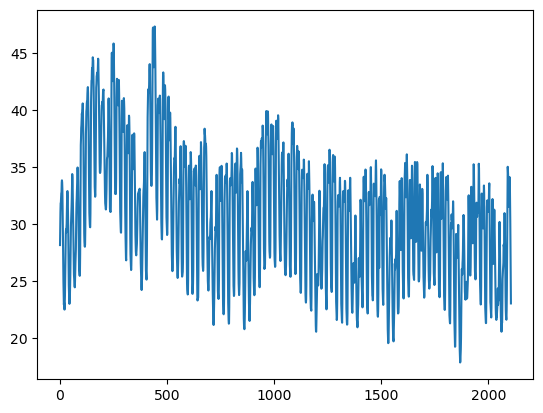

In [19]:
plt.plot(y_true)